# Churn modeling with machine learning: Medium.com employee data

In this notebook we continue the analysis of the human resources data provided by Medium on Kaggle (https://www.kaggle.com/ludobenistant/hr-analytics). It is simulated employee data of 14999 employees, and the goal is to understand something about what might cause an employee to prematurely leave the company.

The fact that we have some useful demographics about our employees, and that we know if the employee left or not means we can apply machine learning to model the data, and we can use supervised learning algorithms. As this is a classification problem (with two outcomes, will leave, or will stay) I will apply a suite of standard classification algorithms: logistic regression, random forest, and SVM. From our preliminary data exploration, we found that the majority of people who leave cluster into one of three groups, depending on satisfaction level, working hours, and number of projects. This suggest that the model is strongly non-linear or conditional. 

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [3]:
from __future__ import print_function

In [4]:
sns.set_context("talk")

## Contents

<a href=#data_reading>1. Data reading and preprocessing</a><br>
<a href=#data_exploration>2. Data exploration</a><br>
<a href=#correlation_matrix>2.1 Correlation matrix</a><br>
<a href=#pair_plots>2.2. Pair plots</a><br>
<a href=#pvalue>2.3. p-value calculation</a><br>
<a href=#machine_learning>3. Machine Learning modeling</a><br>
<a href=#logistic_regression>3.1. Logistic regression</a><br>
<a href=#logreg_poly2>3.1.1. Polynomial terms (2nd degree)</a><br>
<a href=#logreg_poly3>3.1.2. Polynomial terms (3rd degree)</a><br>
<a href=#interaction>3.1.3. Interaction terms</a><br>
<a href=#random_forest>3.2. Random Forest</a><br>
<a href=#svm>3.3. Support Vector Machines</a><br>
<a href=#linear_kernel>3.3.1. Linear kernel</a><br>
<a href=#rbf_kernel>3.3.2. RBF kernel</a><br>
<a href=#poly_kernel>3.3.3. Polynomial kernel</a><br>
<a href=#discussion>4. Discussion</a><br>
<a href=#recommendations>5. Recommendations</a><br>

## 1. Data reading and preprocessing <a name='data_reading' /> 

The data comes as a comma separated text file. The data is pretty clean, as there is no missing data, and formats are all sensible. Ratings are already normalized to be between 0 and 1. We just need to convert categorical columns into dummy variables (for each category, there is a column associated with it with a value of true or false, depending on if it is that category). We're ready to start looking for interesting features in the data!

In [5]:
#data is comma-delimited csv, with headers in the first line
dfraw = pd.read_csv('HR_comma_sep.csv')

In [6]:
#rename column sales to dept, fix typo in average_montly_hours
dfraw = dfraw.rename(columns={'sales':'dept'})
dfraw = dfraw.rename(columns={'average_montly_hours':'average_monthly_hours'})

In [7]:
dfraw.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_monthly_hours      int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
dept                      object
salary                    object
dtype: object

In [8]:
#create dummy variables for columns that are categorical: dept, and salary
df = pd.get_dummies(dfraw)
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'dept_IT', 'dept_RandD', 'dept_accounting',
       'dept_hr', 'dept_management', 'dept_marketing', 'dept_product_mng',
       'dept_sales', 'dept_support', 'dept_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

<a href=#contents>(back to top)</a>

## 2. Data exploration <a name='data_exploration' />

We have lots of interesting information that might impact an employee's attitudes. We have direct measures of her general happiness level (satisfaction_level) and her employer's attitude about her (last_evaluation). A measure of workload can be gauged from number of projects and average monthly hours. A measure of rewards from the employer can be found in salary and number of promotions in the last 5 years. Her status in the company could be gleaned from her salary level, department, time spent at the company, and number of projects. 

When measuring how well the models perform, a metric used is accuracy - what percent of the test cases were predicted correctly. A baseline model against which we will compare these models is a model where all people are predicted to stay. As you see below the percentage of people who leave in our dataset is 24%. Therefore the baseline model will be 76% accurate just predicting that everyone stays.

In [9]:
#How many people leave?
print('Ratio of people who leave: {:.2f}'.format(df.left.mean()) )

Ratio of people who leave: 0.24


<a href=#contents>(back to top)</a>

### 2.1. Correlation matrix <a name='correlation_matrix' />

The first thing one can check for is any relationships between the features and the churn variable directly. A correlation matrix of the data will give an indication of any linear relationships at a glance. Note that the categorical features and their N dummy variables have N-1 degrees of freedom, and have an internal correlation. 

<IPython.core.display.Javascript object>


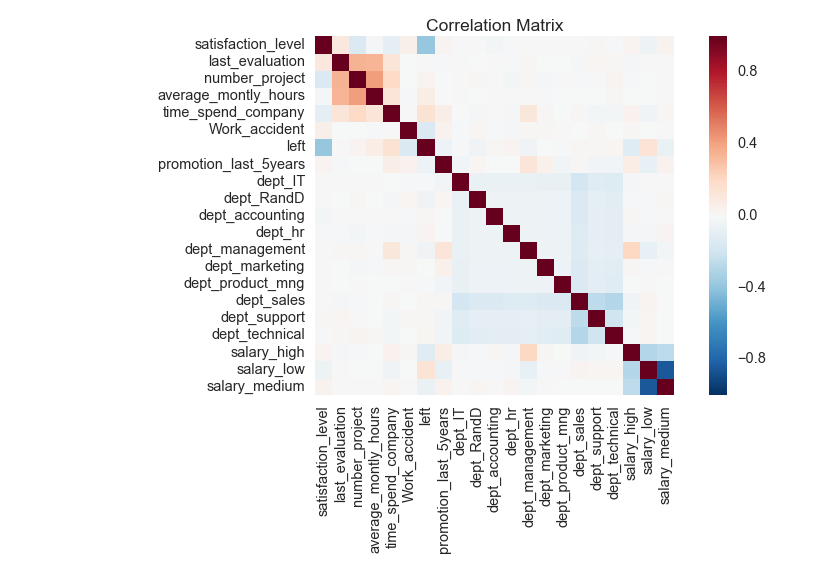

In [10]:
corrmat = df.corr()
plt.figure()
sns.heatmap(corrmat, vmax=1., square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.tight_layout();

We can see that the features that have some direct correlation with leaving is satisfaction level, along with at a lesser level time spent at the company and a low salary. Between the features, there is positive correlation among last_evaluation, number_project, and average_monthly_hours, and to a lesser degree time_spend_company and satisfaction_level. There are also correlations between being in management and a high salary, getting a promotion in the last 5 years, and the time spent in the company. There is also some correlation between categories within the same features, as highlighted above.

To make sure a correlation is significant, the p-value is also calculated. The calculation for the p-values are shown at the end of this section; All p-values were less than 0.01, so all correlations are significant.

<a href=#contents>(back to top)</a>

### 2.2. Pair plots <a name='pair_plots' />

Let's plot pairwise plots to look closer at the relationships between features; this is a luxury we can afford because we only have 9 features in our data set. Coloring by the churn variable, we can see how the different cases might behave differently. The package seaborn has some great plotting functions that make it easy to do this.

<IPython.core.display.Javascript object>


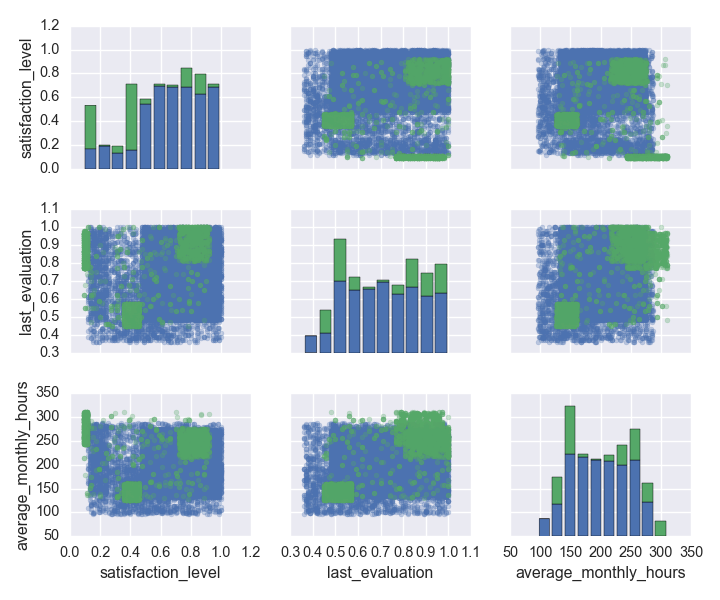

In [15]:
#continuous variables
g = sns.PairGrid(df, hue='left', vars=['satisfaction_level', 'last_evaluation', 'average_monthly_hours'],aspect=1.2)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter,alpha=0.3)

<IPython.core.display.Javascript object>


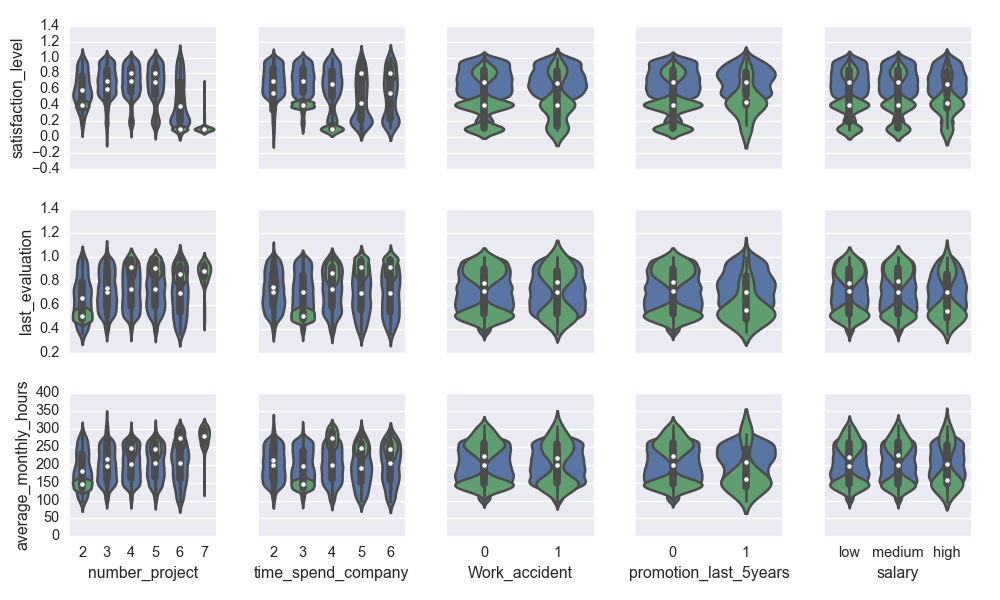

In [10]:
#continuous vs ordinal/categorical data; plot dept on own
g = sns.PairGrid(dfraw, hue='left', y_vars=['satisfaction_level', 'last_evaluation', 'average_monthly_hours'],
                  x_vars=['number_project', 'time_spend_company', 'Work_accident', 
                          'promotion_last_5years', 'salary'])
g = g.map(sns.violinplot)

<IPython.core.display.Javascript object>


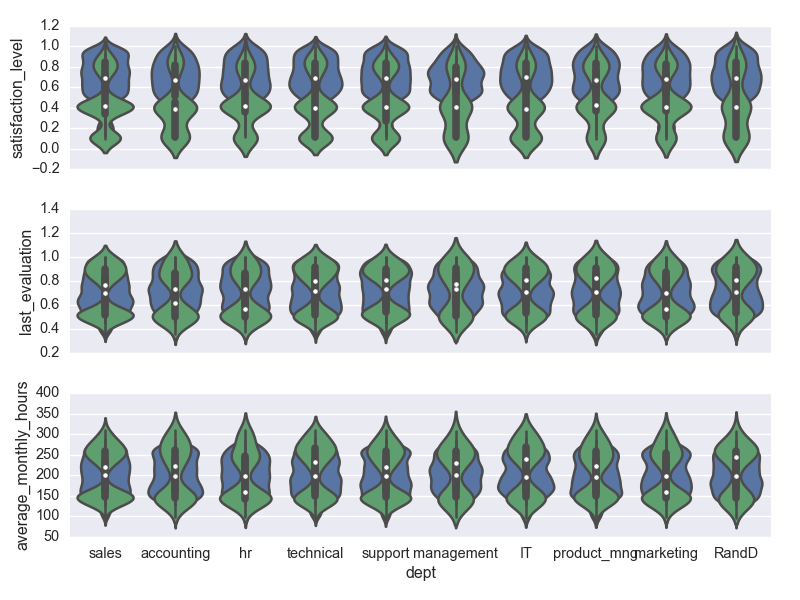

In [12]:
g = sns.PairGrid(dfraw, hue='left', y_vars=['satisfaction_level', 'last_evaluation', 'average_monthly_hours'],
                  x_vars=['dept'], aspect=4.0)
g = g.map(sns.violinplot)

<IPython.core.display.Javascript object>


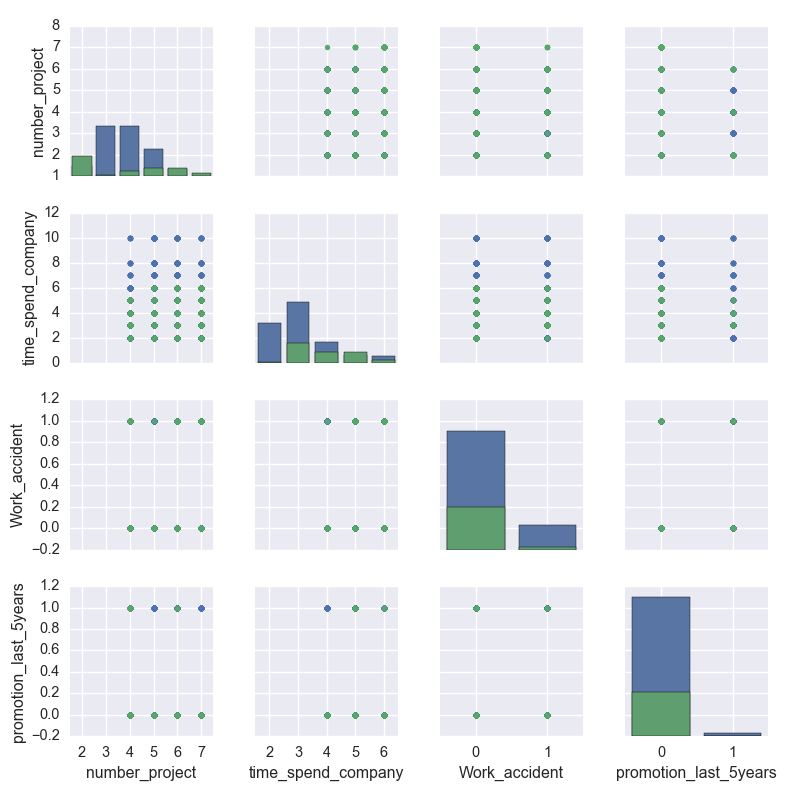

In [19]:
#ordinal variables
g = sns.PairGrid(df, hue='left', vars=['number_project', 'time_spend_company', 'Work_accident', 
                                       'promotion_last_5years'])#, 'dept', 'salary'])
g = g.map_diag(sns.countplot)
g = g.map_offdiag(plt.scatter)

Some thoughts that come up looking at the plots are: 
* there is a bimodal distribution for leaving - seems there are two peaks in most plots for leavers - those who have high or low satisfaction, high or low evaluations, and those who work part-time or overtime.
* there are clearly three clusters of leavers when monthly hours and satisfaction level are compared: people who work part-time and have medium satisfaction levels and evaluations, people who work overtime and have high satisfaction levels and evaluations, and people who work overtime and have very low satisfaction levels but high evaluations.
* there are no leavers if the employee has stayed over 6 years. Leavers will leave within 6 years.

There seems to be an interesting story behind the satisfaction vs work hours plots. Do they partition by department, or number of projects? The answer is it does partition very neatly with number of projects, but not with other features.

In [49]:
#how many in each cluster?
df['cluster_number'] = 1*df.left*(\
    ((df.satisfaction_level>0.3)&(df.satisfaction_level<0.5)&\
     (df.last_evaluation>0.4)&(df.last_evaluation<0.5)) ) + \
    2*df.left*(\
    ((df.satisfaction_level>0.7)&(df.satisfaction_level<=1.0)&\
     (df.last_evaluation>0.8)&(df.last_evaluation<=1.0)) ) + \
    3*df.left*(\
    ((df.satisfaction_level>0.05)&(df.satisfaction_level<0.15)&\
     (df.last_evaluation>0.75)&(df.last_evaluation<=1.0)) )

df.groupby(['left','cluster_number']).size()

left  cluster_number
0     0                 11428
1     0                  1228
      1                   567
      2                   890
      3                   886
dtype: int64

<IPython.core.display.Javascript object>


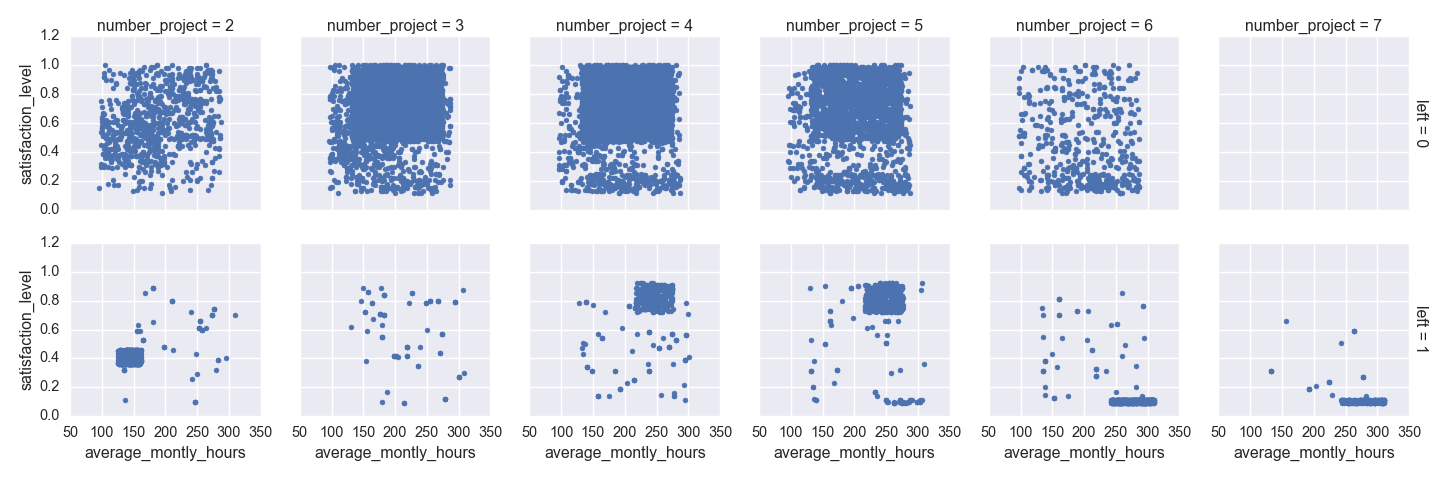

In [11]:
# satisfaction vs work hours for number of projects  
g = sns.FacetGrid(df, col="number_project", row="left", margin_titles=True)
g.map(plt.scatter, "average_monthly_hours", "satisfaction_level");

<IPython.core.display.Javascript object>


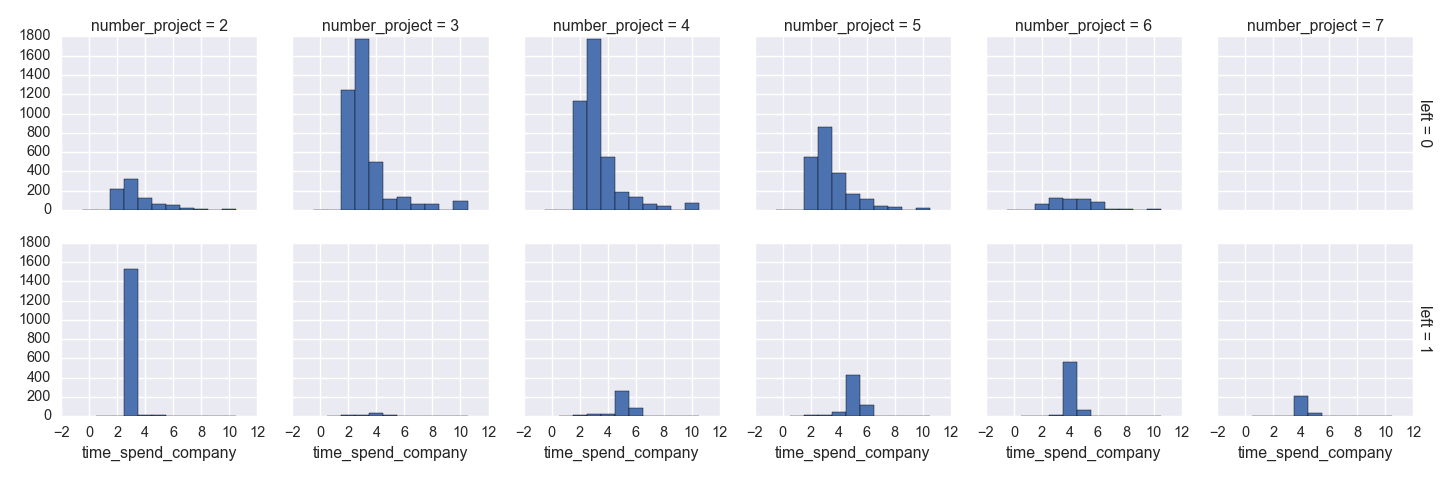

In [14]:
# satisfaction vs time at company for number of projects  
g = sns.FacetGrid(df, col="number_project", row="left", margin_titles=True)
g.map(plt.hist, "time_spend_company", bins = np.arange(-.5, 11.5, 1));

Those with less than full time hours (less than 176 hours per month) were not vastly unhappy, so a possible interpretation is that people in this group desire more responsibility and a full time job, and therefore leave, or perhaps they are bored and therefore leave. This is supported by lukewarm evaluations. While the distribution of evaluations span from 0.3 to 1.0, the majority of those who leave have evaluations of 0.4-0.6. Helpful knowledge might be to parse satisfaction level into different aspects like sense of responsibility, number of hours, or work topic. If they are hoping to be turned full time and aren't, there might be a threshold under which people leave. This can be seen in that the majority of those who leave with 2 projects leave at 3 years.
 
Those who worked overtime and had 4-5 projects were very satisfied (rating of >0.7). A possible interpretation is that the number projects felt manageable, hence the high satisfaction level, they worked overtime because they wanted to, and they left because they simply got better offers. Such people would be expected to get good evaluations, which is the case evaluations were greater than 0.8.
 
Those who worked overtime and had 6-7 projects and are very unsatisfied (rating of 0.1). In fact, all the people with 7 projects leave. A possible interpretation is that the number of concurrent projects was too overwhelming, leading to the forced overtime, and a desire to leave and find a more manageable or financially rewarding situation. Those who left also had high evaluations, of greater than 0.75. They might be overworked and unhappy and therefore motivated to leave their job, but since they are doing their job well, and they are able to get another job.

In [13]:
df.groupby(['number_project','left']).size()

number_project  left
2               0        821
                1       1567
3               0       3983
                1         72
4               0       3956
                1        409
5               0       2149
                1        612
6               0        519
                1        655
7               1        256
dtype: int64

In [15]:
#How many people get promotions?
df.groupby([df.promotion_last_5years,df.left]).size()

promotion_last_5years  left
0                      0       11128
                       1        3552
1                      0         300
                       1          19
dtype: int64

In [16]:
print('Ratio who got promotions in last 5 years: {:.2f}'.format(319/14999))
print('Ratio of promoted who leave: {:.2f}'.format(19/(300+19)))
print('Ratio of those not promoted who leave: {:.2f}'.format(3552/(11128+3552)))

Ratio who got promotions in last 5 years: 0.02
Ratio of promoted who leave: 0.06
Ratio of those not promoted who leave: 0.24


Would promoting people help? While only 2% of people got promotions in the last 5 years, out of those who do only 6% leave. Otherwise, 24% of people leave. In comparison, out of the people with only two projects, 66% leave, which is 1567 people. Those with four or five projects mostly stay; 14% churn, which is 1021. And those with six or seven projects mostly leave with all people with seven projects leaving; 64% of these people leave, which is 911 people. 

For another look at the data, please take a look at the accompanying Data Story notebook, where I step through the stream of consciousness exploration of an unknown dataset. 

<a href=#contents>(back to top)</a>

### 2.3. p-value calculation <a name='pvalue' />

Calculations of the p-value for specific pairs of features which had noticeable correlation coefficients. All of the p-values are less than 0.01. 

In [17]:
from scipy.stats import pearsonr
#correlation and pvalues for first 5 features
coeffmat = np.zeros((5, 5))
pvalmat = np.zeros((5, 5))

for i in range(5):    
    for j in range(5):        
        corrtest = pearsonr(df[df.columns[i]], df[df.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=df.columns[0:5], index=df.columns[0:5])
dfpval = pd.DataFrame(pvalmat, columns=df.columns[0:5], index=df.columns[0:5])
print('Correlation Coefficient')
print(dfcoeff)
print('\nP values')
print(dfpval)

Correlation Coefficient
                      satisfaction_level  last_evaluation  number_project  \
satisfaction_level              1.000000         0.105021       -0.142970   
last_evaluation                 0.105021         1.000000        0.349333   
number_project                 -0.142970         0.349333        1.000000   
average_montly_hours           -0.020048         0.339742        0.417211   
time_spend_company             -0.100866         0.131591        0.196786   

                      average_montly_hours  time_spend_company  
satisfaction_level               -0.020048           -0.100866  
last_evaluation                   0.339742            0.131591  
number_project                    0.417211            0.196786  
average_montly_hours              1.000000            0.127755  
time_spend_company                0.127755            1.000000  

P values
                      satisfaction_level  last_evaluation  number_project  \
satisfaction_level          0.000000

In [18]:
#correlation and pvalues for management and high salary, getting a promotion, and time spent
colnames = ['salary_high','promotion_last_5years','time_spend_company']
res = []
for colname in colnames:    
    res.append(pearsonr(df['dept_management'], df[colname]))  
coeffs,pvals = zip(*res)
dfcoeff = pd.DataFrame(np.array([coeffs]), columns=colnames, index=['dept_management'])
dfpval = pd.DataFrame(np.array([pvals]), columns=colnames, index=['dept_management'])
print('Correlation Coefficients')
print(dfcoeff)
print('\nP Values')
print(dfpval)

Correlation Coefficients
                 salary_high  promotion_last_5years  time_spend_company
dept_management     0.209077               0.128087            0.115436

P Values
                   salary_high  promotion_last_5years  time_spend_company
dept_management  8.580703e-148           6.821772e-56        1.154434e-45


In [19]:
#correlation and pvalues for leaving and satisfaction level, time spent, and low salary
colnames = ['satisfaction_level','time_spend_company','salary_low']
res = []
for colname in colnames:    
    res.append(pearsonr(df['left'], df[colname]))  
coeffs,pvals = zip(*res)
dfcoeff = pd.DataFrame(np.array([coeffs]), columns=colnames, index=['left'])
dfpval = pd.DataFrame(np.array([pvals]), columns=colnames, index=['left'])
print('Correlation Coefficients')
print(dfcoeff)
print('\nP Values')
print(dfpval)

Correlation Coefficients
      satisfaction_level  time_spend_company  salary_low
left           -0.388375            0.144822    0.134722

P Values
      satisfaction_level  time_spend_company    salary_low
left                 0.0        4.207680e-71  1.079994e-61


<a href=#contents>(back to top)</a>

## 3. Machine Learning modeling <a name='machine_learning' />

We apply three standard machine learning models to the medium.com HR data: logistic regression, random forest, and support vector machines (SVM). These techniques work well when the data is "tall" - when there are more data points than features; in our case we have 14999 data points and nine features (20 when expanded into dummy variables). From data exploration we know that the data is nonlinear and displays a patchwork pattern that should be well captured by random forest. Clustering can be captured by polynomial terms in both logistic regression and SVM. In terms of computational intensity, both logistic regression and random forest are fast; SVM is much more intensive.

We have labels that tell us what the real answer is, but we want to test our model as if it were encountering new data. This is possible by dividing the data into two subsets, training the model on the larger subset, and testing prediction with the other - this is called cross validation. A way to train and test, while subjecting all data to training and testing, is to divide the data into K equal parts, where each part will be used as the test data in one run of the training-test cycle, with the remaining data used as training data. So the training and testing will be run K independent times. This is called a K-Fold cross validator. The sci-kit learn package provides handy functions that make implementing this as easy as possible. If your data has a greater percentage of a certain result value, you can ensure the ratio is consistent between folds using StratifiedKFold, which we do in this case.

To get the best performance, we select the values of the input parameters that result in the best accuracy; this is accomplished easily with a grid search, meaning, trying every combination of manually input parameter values and returns the best parameter combination based on performance using cross validation. This is accomplished with the sci-kit learn tool GridSearchCV.

For each of the models, the performance is characterized by standard prediction metrics such as:
 * confusion matrix (true positives, false positives, true negatives, false negatives)
 * plot the true positives rate vs the false positives rate, aka receiver operating characteristic (ROC) curve; the ideal case would look like a right angle with the bend in the (0,1) corner.
 * precision-recall (PR) curve; precision is the true positives over all predicted positives, and recall is the true positives over all real positives. great for unbalanced datasets since it ignores true negatives. The ideal case would look like a right angle with the bend in the (1,1) corner.
 * the area under the curve (AUC) for the ROC and PR curves (larger values are better) 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute ROC curve and area the curve
def plot_roc(y_test,y_score):
    lw = 2
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=lw,
             label='ROC')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve: AUC={0:0.2f}'.format(roc_auc))
    plt.legend(loc="lower right")
    plt.show()
    
# Plot Precision-Recall curve
def plot_pr(y_test,y_score):
    lw = 2
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)

    plt.figure()
    plt.plot(recall, precision, lw=lw, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC={0:0.2f}'.format(average_precision))
    #plt.legend(loc="lower left")
    plt.show()

To summarize, for each model, the same process was followed:
* grid search for optimizing fit parameters by testing all combinations of inputs, like C which is the inverse regularization coefficient 
* run the best model with cross validation using K-fold methodology. This means for each "fold", train the model, and then test. See which features have the most impact on the target variable, for each fold.
* calculate performance metrics

<a href=#contents>(back to top)</a>

### 3.1. Logistic regression <a name='logistic_regression' />

Logistic regression is a regression model where the output is categorical, and in the simplest case, has two values. In our case we have just two values in our churn variable. One thing to keep in mind is if some features are highly correlated, then the coefficients to those features may not be indicative of their true weight. For categorical data (department and salary) where the value must be one of n categories, the degrees of freedom is actually n-1; if you know the value for the first n-1 categories, the value for the nth category is deterministic. Therefore we delete one of the dummy columns per feature. Use of L1 regularization can help eliminate features that have very little impact on the churn variable. 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

See how well default model fits to the data.

In [46]:
X = df.drop(['left','salary_medium','dept_IT'], axis=1).values
y = df.left.values
Xlabels = df.drop(['left','salary_medium','dept_IT'], axis=1).columns

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.794
Accuracy score of test set: 0.780


Recall that a baseline model that predicts everyone stays has 0.76 accuracy; this model is not doing much better.

Tweak the input parameters, such as C, the inverse regularization coefficient.

In [25]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [0.001, 0.1, 1, 10, 100, 1000, 10000]
lr = LogisticRegression(penalty='l1')
clf = GridSearchCV(lr, {'C':Cs})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X, y)))

{'C': 1000}
Accuracy score: 0.792


We now know what value of C provides a better score, though, it's not greatly different from score of the default value of C=1, so we will just use the default. Now we apply k-fold cross validation, to test out the stability of feature importance.

In [14]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression(penalty='l1')

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(X[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [15]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 0.7994002   0.79333333  0.80666667  0.79193064  0.65721907]
Mean accuracy score: 0.77


<IPython.core.display.Javascript object>


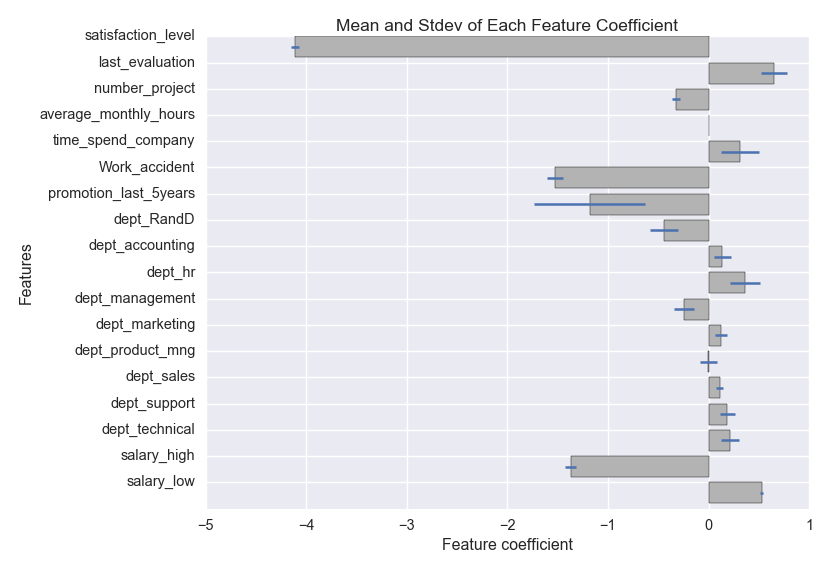

In [16]:
#plot mean and standard deviation of coefficient values for each features over the folds
xerr=np.std(f_impo,axis=0)
plt.figure()
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr,color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')
plt.title('Mean and Stdev of Each Feature Coefficient')
plt.gca().invert_yaxis()
plt.tight_layout();

<IPython.core.display.Javascript object>


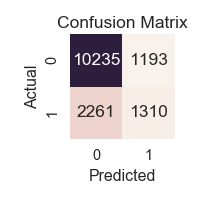

In [17]:
plt.figure(figsize=(2.5,2.5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

<IPython.core.display.Javascript object>


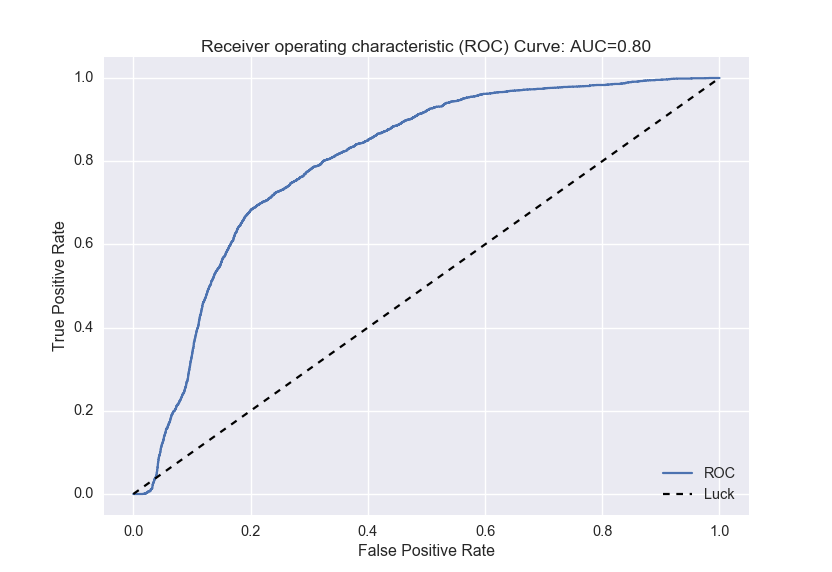

In [38]:
plot_roc(y_true,decfun)

<IPython.core.display.Javascript object>


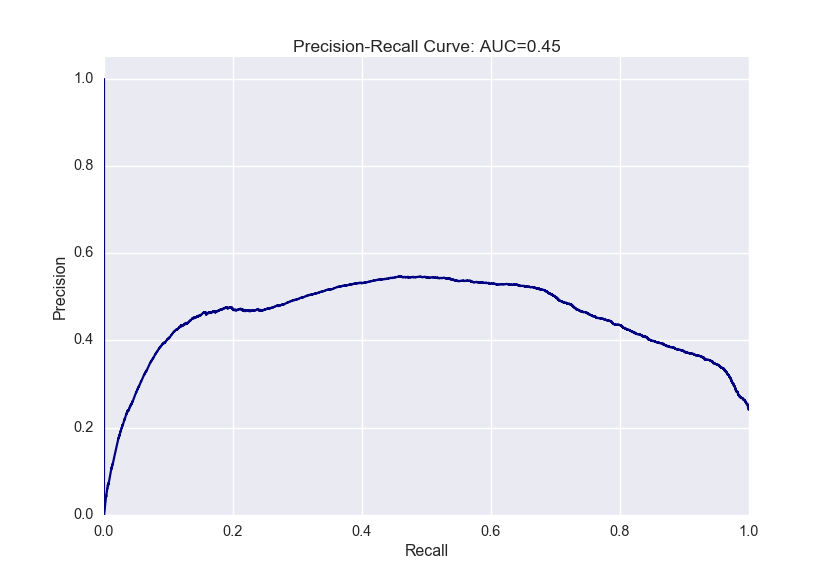

In [39]:
# Plot Precision-Recall curve
plot_pr(y_true,decfun)

The accuracy of the model is 77%, which is about the same as the baseline model. We can see from the confusion matrix that the majority of actual positives are predicted to be negatives; the true positive rate (aka recall) is a measly 37%. Only half of those predicted as positives are actual positives; the precision is 52%. Ideally these would be close to 100%.

The ROC curve shows the model is better than random. The area under the curve (AUC) is 0.8 (ideal is 1.0). As mentioned above, the precision and recall of our dataset is very poor, which is reflected in the precision-recall (PR) curve and the poor AUC for the PR curve (0.45).

<a href=#contents>(back to top)</a>

### 3.1.1. Polynomial terms (2nd degree) <a name='logreg_poly2' />

While logistic regression is a linear model - it is possible to fit non-linear behavior by adding features that are non-linear combinations of the original features. We now apply second and third degree polynomials, and just the interaction terms.

In [47]:
poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)

In [48]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,Xpoly.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression()

for train, test in StratifiedKFold(nfold).split(Xpoly, y):
    clf.fit(Xpoly[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(Xpoly[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(Xpoly[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(Xpoly[test],y[test])
    offset += len(test)
    n += 1

In [20]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 0.87037654  0.853       0.847       0.86062021  0.81093698]
Mean accuracy score: 0.85


<IPython.core.display.Javascript object>


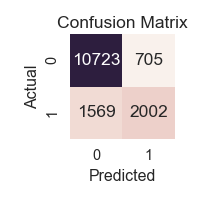

In [21]:
plt.figure(figsize=(2.5,2.5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

The accuracy of the model is 85%. We can see from the confusion matrix that over half of actual positives are predicted to be positive; the true positive rate (aka recall) is 56%. Most of those predicted as positives are actual positives; the precision is 74%. Ideally these would be close to 100%. These numbers show that the data is better modeled with nonlinear relationships.

<IPython.core.display.Javascript object>


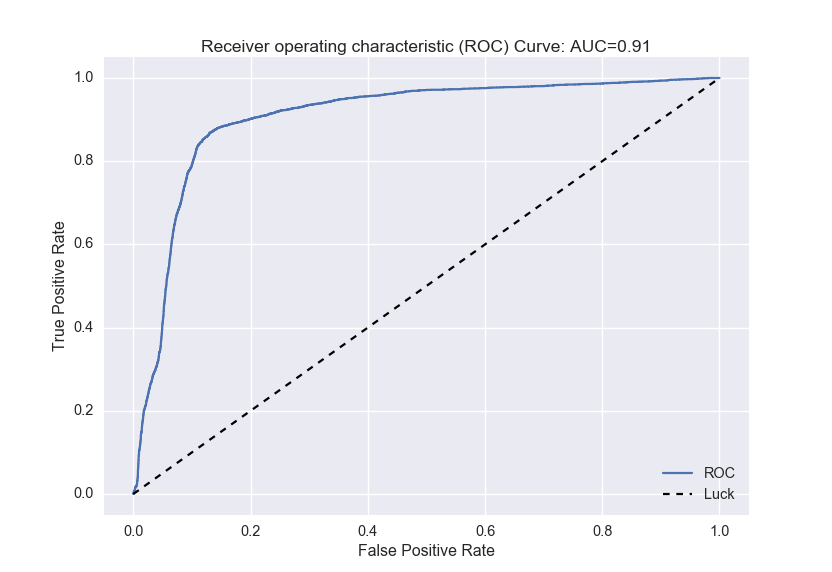

In [49]:
plot_roc(y_true,decfun)

<IPython.core.display.Javascript object>


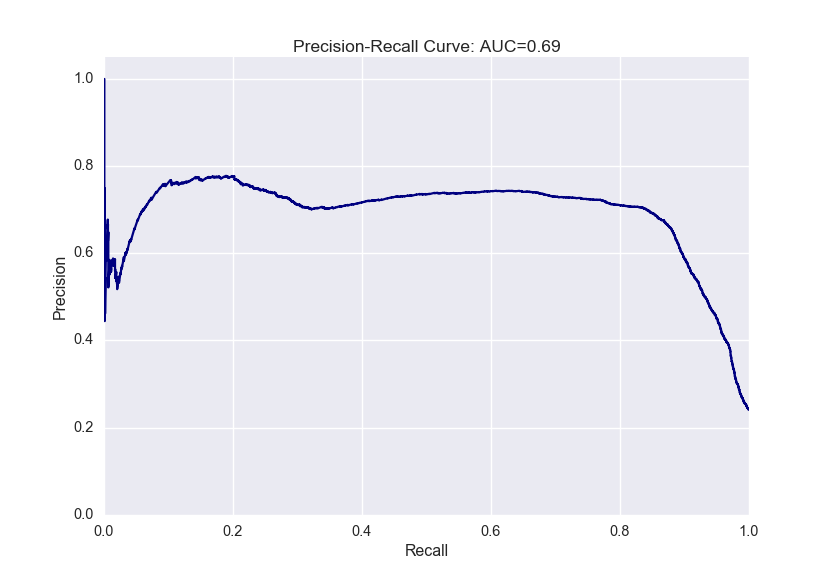

In [45]:
plot_pr(y_true,decfun)

<a href=#contents>(back to top)</a>

### 3.1.2. Polynomial terms (3rd degree) <a name='logreg_poly3' />

In [22]:
poly = PolynomialFeatures(degree=3)
Xpoly = poly.fit_transform(X)

In [23]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,Xpoly.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression()

for train, test in StratifiedKFold(nfold).split(Xpoly, y):
    clf.fit(Xpoly[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(Xpoly[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(Xpoly[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(Xpoly[test],y[test])
    offset += len(test)
    n += 1

In [24]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 0.82605798  0.83133333  0.81866667  0.82894298  0.83161054]
Mean accuracy score: 0.83


<IPython.core.display.Javascript object>


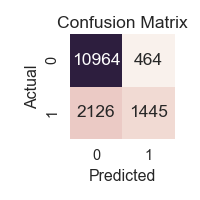

In [25]:
plt.figure(figsize=(2.5,2.5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

The accuracy of the model is 83%. We can see from the confusion matrix that the model leans towards false negatives. The true positive rate (aka recall) is 40%. Most of those predicted as positives are actual positives; the precision is 76%. Ideally these would be close to 100%. Seems the second degree polynomial model is more accurate than the third degree polynomial, but this could be because of the huge increase of features that happens when increasing the degree of the polynomial.

<IPython.core.display.Javascript object>


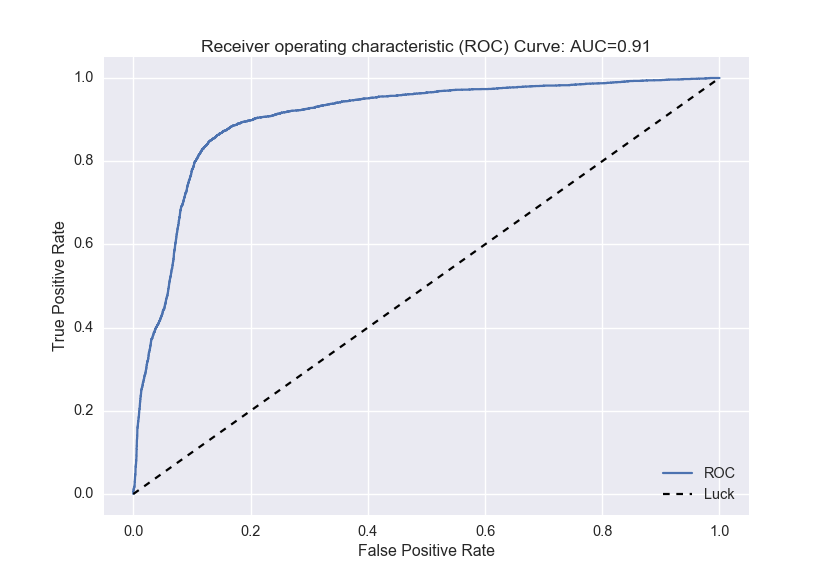

In [50]:
plot_roc(y_true,decfun)

<IPython.core.display.Javascript object>


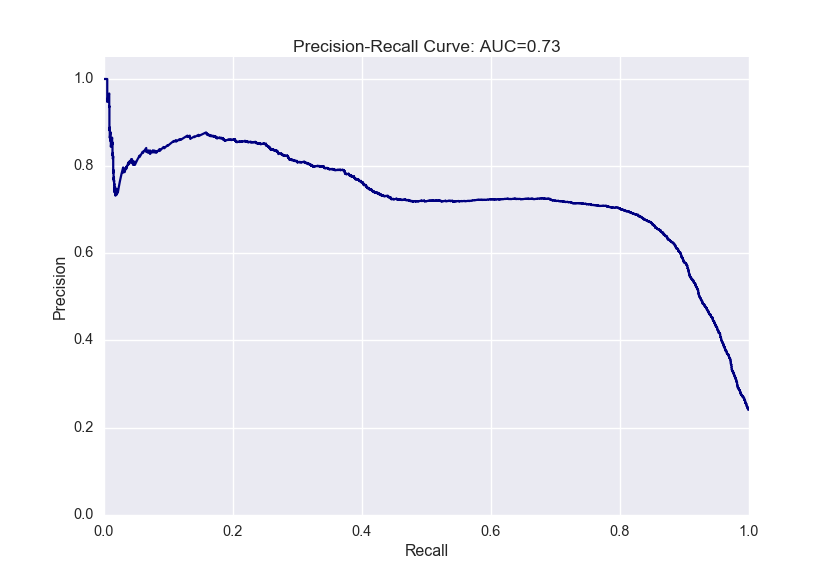

In [51]:
plot_pr(y_true,decfun)

<a href=#contents>(back to top)</a>

### 3.1.3. Interaction terms <a name='interaction' />

Here we only include the interaction terms.

In [26]:
poly = PolynomialFeatures(interaction_only=True)
Xinter = poly.fit_transform(X)

In [27]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,Xinter.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = LogisticRegression()

for train, test in StratifiedKFold(nfold).split(Xinter, y):
    clf.fit(Xinter[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(Xinter[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.decision_function(Xinter[test])
    f_impo[n,:] = clf.coef_
    n_scor[n] = clf.score(Xinter[test],y[test])
    offset += len(test)
    n += 1

In [28]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 0.92769077  0.918       0.91466667  0.92930977  0.8396132 ]
Mean accuracy score: 0.91


<IPython.core.display.Javascript object>


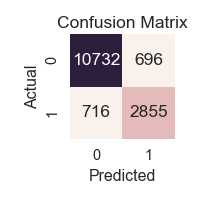

In [29]:
plt.figure(figsize=(2.5,2.5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

We can see from the confusion matrix that while there are still false positives and negatives, it doesn't bias towards one of them. The true positive rate (aka recall) is 80%. Most of those predicted as positives are actual positives; the precision is 80%. Ideally these would be close to 100%. 

<IPython.core.display.Javascript object>


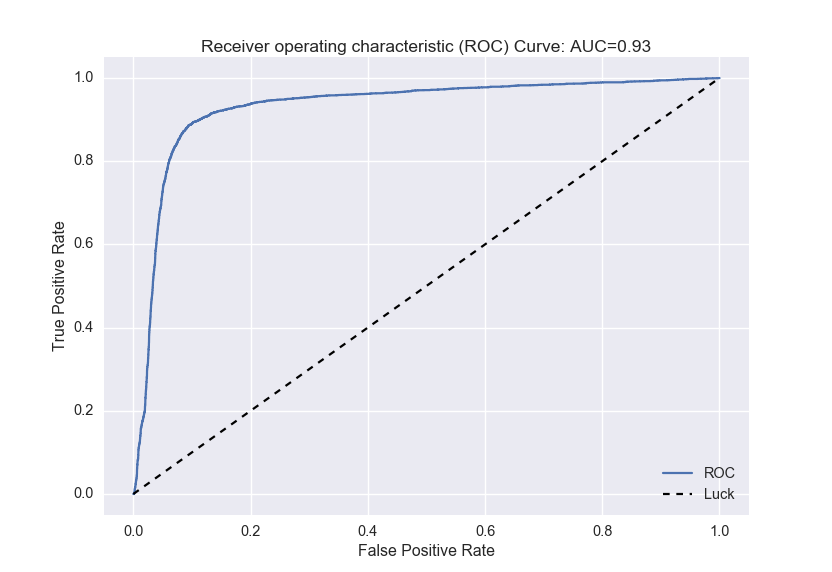

In [56]:
plot_roc(y_true,decfun)

<IPython.core.display.Javascript object>


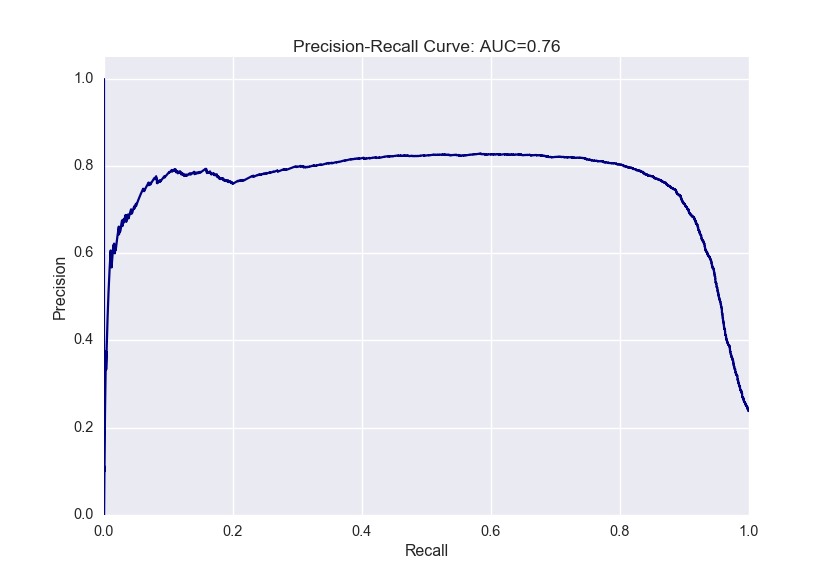

In [57]:
plot_pr(y_true,decfun)

We tried the model with second degree polynomial terms, third degree polynomial terms, and simply interaction terms. The accuracy of these models were respectively 85%, 83%, and 91%. This could be a result of the explosion of features that happens when increasing the degree of the polynomial, and the resulting sparseness of the space the model has to work within.

The ROC curves showed that the models were better than random, and that nonlinear models were better at separating negative and positive cases better. The best result came from the interaction terms, with the area under the curve (AUC) being 0.93 (ideal is 1.0). The PR curve is also improved over the linear case, with an AUC for the PR curve of 0.76.

<a href=#contents>(back to top)</a>

## 3.2. Random Forest <a name='random_forest' />

Decision trees are great for nonlinear and conditional relationships. They are also fast, but prone to overfitting. In practice the ensemble technique of random forest is used instead of a single decision tree. Random forest runs a number of decision trees on a subset of the data, and averages to improve prediction and counteract overfitting. This model also provides a measure of feature importance.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

In [31]:
X = df.drop('left', axis=1).values
y = df.left.values
Xlabels = df.drop(['left'], axis=1).columns

First, a quick check of how well the default model works on the data on a simple split of training and test data.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [61]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.999
Accuracy score of test set: 0.987


The fit is already very good, for the training and test set. Can the fit be tweaked even better? Use GridSearchCV to find best parameters.

In [62]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
nEs = [10, 100, 500]
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, {'n_estimators':nEs})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X,y)))

{'n_estimators': 500}
Accuracy score: 1.000


In [63]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.000
Accuracy score of test set: 0.988


In [64]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 1.000
Accuracy score of test set: 0.988


With GridSearchCV, the greater number of estimators has better accuracy, but takes much longer to run. Now, with KFold, to do cross validation, and look at stability of feature importance.

In [33]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
decfun = np.zeros(len(y))
f_impo = np.zeros([nfold,X.shape[1]])
n_scor = np.zeros(nfold)
offset = 0
n = 0

clf = RandomForestClassifier(n_estimators=100)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    decfun[offset:(offset+len(test))] = clf.predict_proba(X[test])[:,1]
    f_impo[n,:] = clf.feature_importances_
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [34]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 0.99866711  0.97833333  0.984       0.99933311  0.99599867]
Mean accuracy score: 0.99


Now that we've run the 5-fold cross validation, let's take a look at the feature importance, and performance metrics. 

<IPython.core.display.Javascript object>


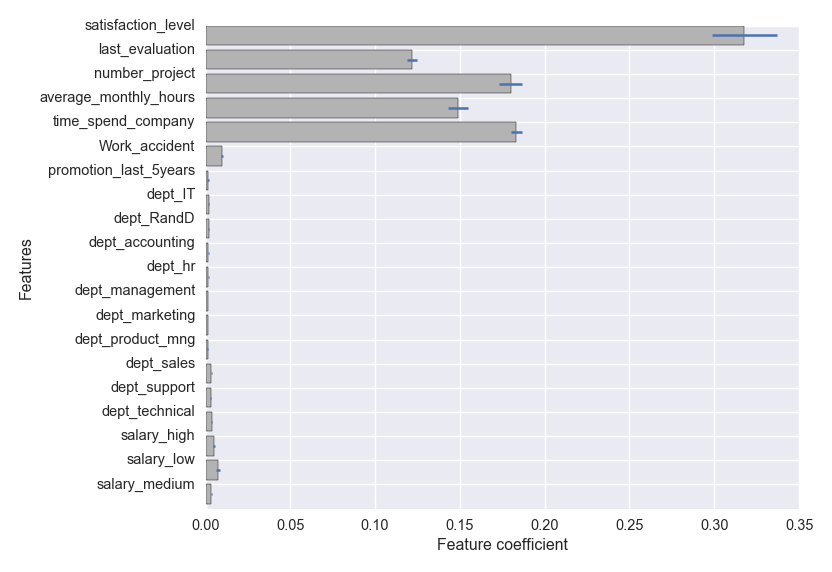

In [68]:
xerr=np.std(f_impo,axis=0)
plt.figure()
plt.barh(range(len(f_impo[0])),np.mean(f_impo,axis=0),xerr=xerr, color='0.7')
plt.yticks(range(len(f_impo[0])),Xlabels,rotation=0)
plt.xlabel('Feature coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout();

Over the five folds in the cross validation, the feature importance stayed very stable, and the five features that are the most important are:
 * satisfaction level
 * last evaluation
 * number of projects
 * average monthly hours
 * time spent at the company

<IPython.core.display.Javascript object>


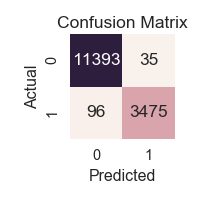

In [35]:
plt.figure(figsize=(2.5,2.5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

<IPython.core.display.Javascript object>


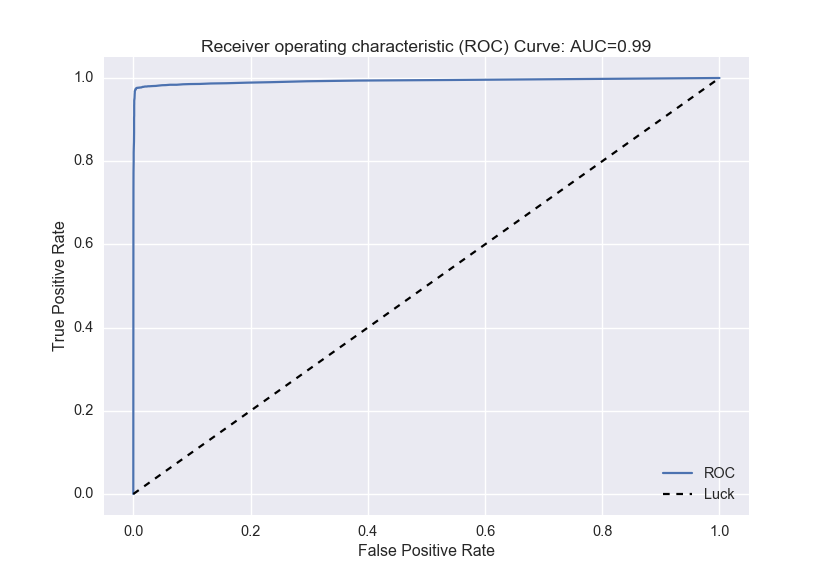

In [69]:
plot_roc(y_true,decfun)

<IPython.core.display.Javascript object>


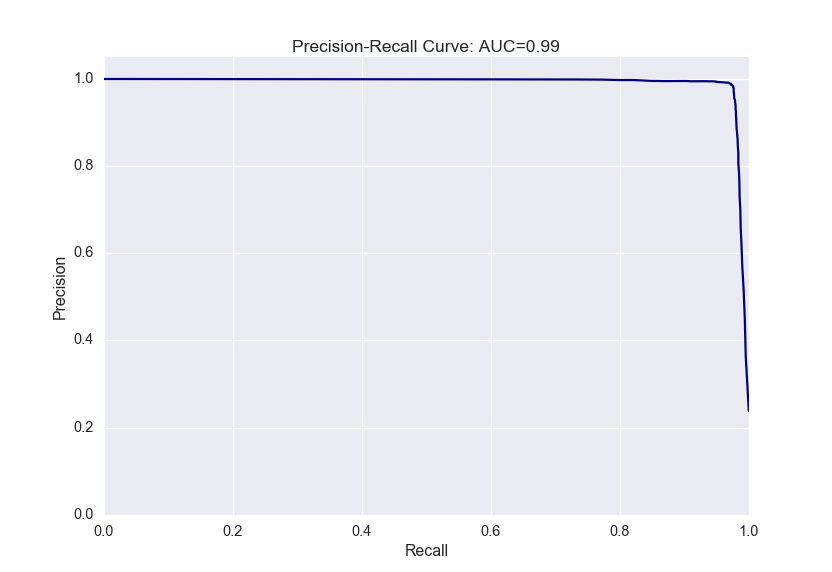

In [70]:
# Plot Precision-Recall curve
plot_pr(y_true,decfun)

Random forest, even the default model, trains and predicts very well on our data. It achieves 99% accuracy in the training and test data. The ROC and PR curves look textbook, with an AUC of both of 0.99, indicating that the model is very good at separating positive and negative cases.

<a href=#contents>(back to top)</a>

## 3.3. Support Vector Machines <a name='svm' />

Support Vector Machines are great for non-linear models, since you can have arbitrarily more dimensions with little additional computational cost, because of the "kernel trick". We will try a series of kernels. It is more difficult to glean learnings from SVM - the coefficients especially for higher order models don't necessarily indicate feature importance.

It is recommended that the data be normalized; SVM is not scale invariant. The SVM algorithm in sci-kit learn takes in both [-1,1] or [0,1]. The columns that will be normalized are number of projects, average monthly hours, time spent in company; all other columns have values between 0 and 1.

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [37]:
X = df.drop('left', axis=1).values
y = df.left.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

<a href=#contents>(back to top)</a>

### 3.3.1. Linear kernel <a name='linear_kernel' />

In [41]:
#see how well the default model works
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.778
Accuracy score of test set: 0.776


In [47]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
svc = SVC(kernel='linear')
clf = GridSearchCV(svc, {'C':Cs,'gamma':gammas})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X,y)))

{'gamma': 1e-05, 'C': 0.1}
Accuracy score: 0.783


In [39]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
y_score = np.zeros((len(y),2))
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = SVC(kernel='linear',C=0.1,gamma=0.00001,probability=True)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    y_score[offset:(offset+len(test))] = clf.predict_proba(X[test])
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [40]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 0.78007331  0.78533333  0.79        0.77892631  0.69956652]
Mean accuracy score: 0.77


<IPython.core.display.Javascript object>


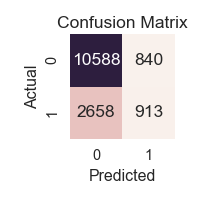

In [41]:
plt.figure(figsize=(2.5,2.5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

<IPython.core.display.Javascript object>


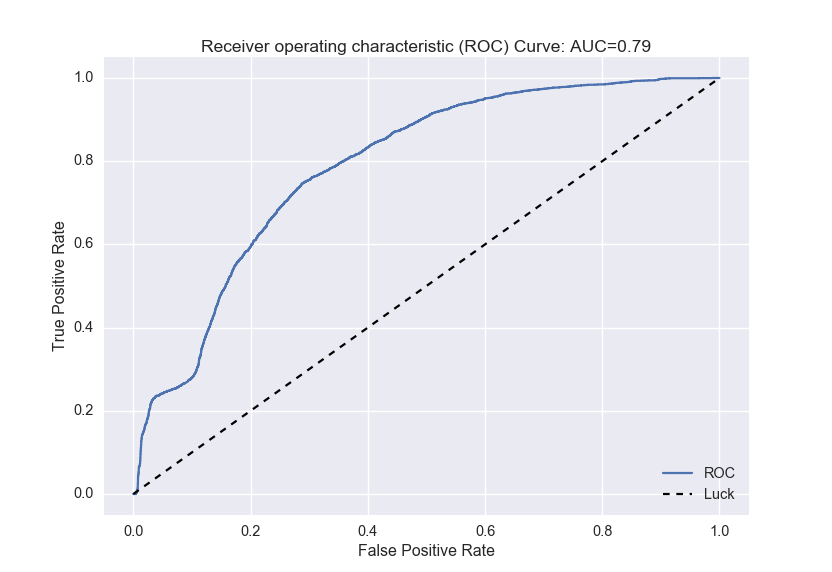

In [77]:
plot_roc(y_true,y_score[:,1])

<IPython.core.display.Javascript object>


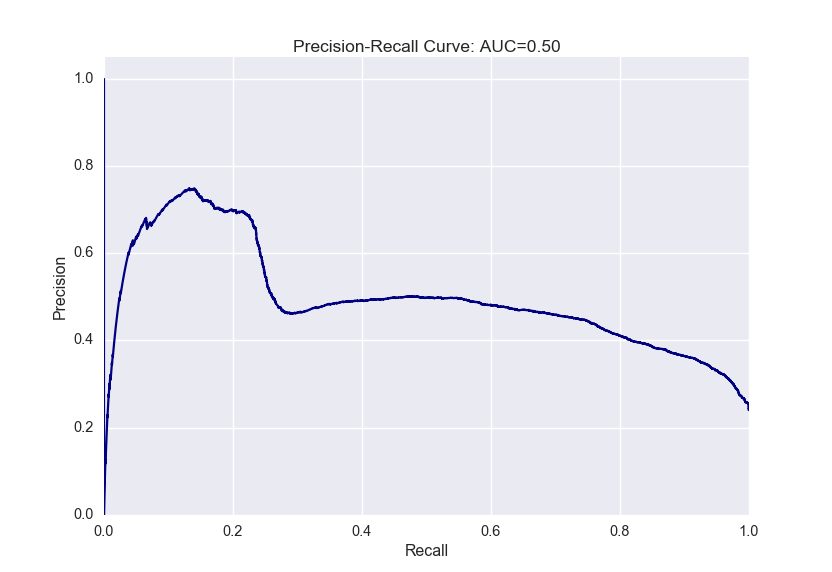

In [78]:
plot_pr(y_true,y_score[:,1])

The linear kernel seems to do as well as the logistic regression, which not great. Let's look at other kernels.

<a href=#contents>(back to top)</a>

### 3.3.2. RBF kernel <a name='rbf_kernel' />

In [13]:
#see how well the default model works
clf = SVC()
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.864
Accuracy score of test set: 0.864


In [18]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [10, 100, 1000, 10000, 100000]
gammas = [0.001, 0.01, 0.1, 1]
svc = SVC()
clf = GridSearchCV(svc, {'C':Cs,'gamma':gammas})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X,y)))

{'C': 10000, 'gamma': 1}
Accuracy score: 0.997


In [ ]:
clf = SVC(gamma=1,C=10000)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.997
Accuracy score of test set: 0.965


In [42]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
y_score = np.zeros((len(y),2))
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = SVC(gamma=1,C=10000,probability=True)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    y_score[offset:(offset+len(test))] = clf.predict_proba(X[test])
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [43]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 0.97167611  0.93733333  0.95        0.975992    0.98266089]
Mean accuracy score: 0.96


<IPython.core.display.Javascript object>


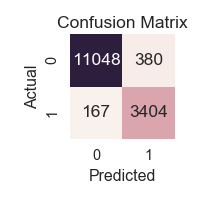

In [44]:
plt.figure(figsize=(2.5,2.5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

<IPython.core.display.Javascript object>


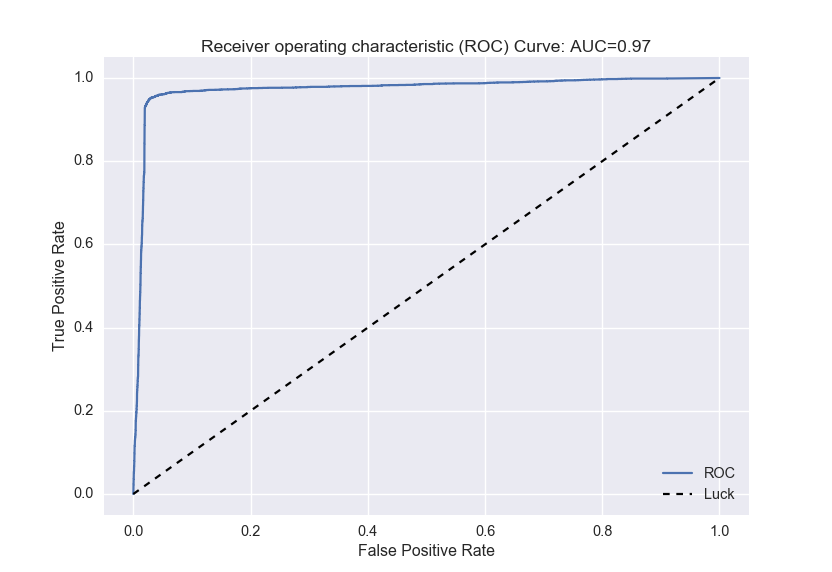

In [83]:
plot_roc(y_true,y_score[:,1])

<IPython.core.display.Javascript object>


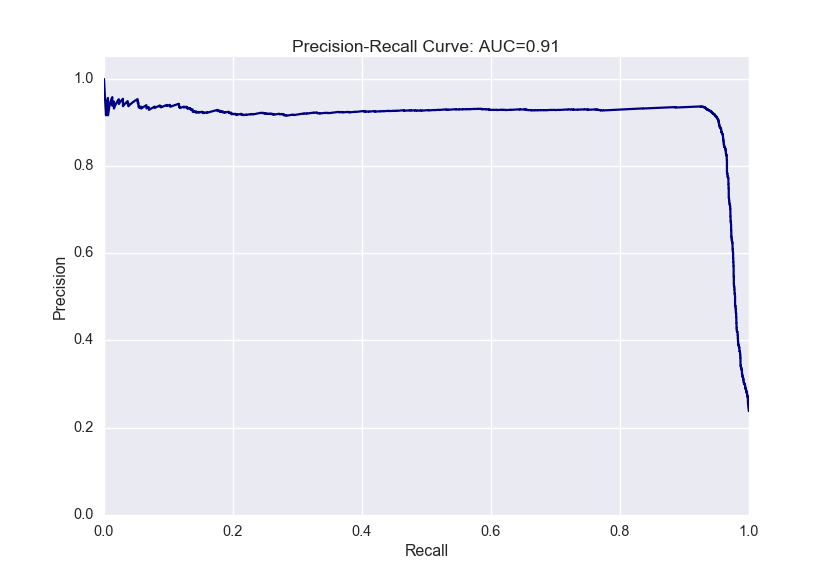

In [84]:
plot_pr(y_true,y_score[:,1])

<a href=#contents>(back to top)</a>

### 3.3.3. Polynomial kernel<a name='poly_kernel' />

In [31]:
clf = SVC(kernel='poly')
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.764
Accuracy score of test set: 0.752


In [85]:
# GridSearchCV by default does cross-validation, so we don't need 
# to manually split the data into training and test data
Cs = [10, 100, 1000, 10000, 100000]
gammas = [0.000001, 0.00001, 0.001, 0.01, 0.1]
svc = SVC(kernel='poly')
clf = GridSearchCV(svc, {'C':Cs,'gamma':gammas})
clf.fit(X, y)
print(clf.best_params_)
print('Accuracy score: {:.3f}'.format(clf.score(X,y)))

{'gamma': 0.1, 'C': 100000}
Accuracy score: 0.974


In [14]:
clf = SVC(kernel='poly',gamma=0.1,C=100000)
clf.fit(X_train, y_train)
print('Accuracy score of training set: {:.3f}'.format(clf.score(X_train,y_train)))
print('Accuracy score of test set: {:.3f}'.format(clf.score(X_test,y_test)))

Accuracy score of training set: 0.976
Accuracy score of test set: 0.963


In [15]:
nfold = 5
y_true = np.zeros(len(y)) # collect test and prediction results
y_pred = np.zeros(len(y))
y_score = np.zeros((len(y),2))
n_scor = np.zeros(nfold)
offset = 0
n = 0
clf = SVC(gamma=0.1,C=100000,probability=True)

for train, test in StratifiedKFold(nfold).split(X, y):
    clf.fit(X[train], y[train])
    y_pred[offset:(offset+len(test))] = clf.predict(X[test])
    y_true[offset:(offset+len(test))] = y[test]
    y_score[offset:(offset+len(test))] = clf.predict_proba(X[test])
    n_scor[n] = clf.score(X[test],y[test])
    offset += len(test)
    n += 1

In [16]:
print('Accuracy scores for each fold:')
print(n_scor)
print ('Mean accuracy score: {:.2f}'.format(np.mean(n_scor)))

Accuracy scores for each fold:
[ 0.97001     0.95066667  0.95633333  0.96932311  0.966989  ]
Mean accuracy score: 0.96


<IPython.core.display.Javascript object>


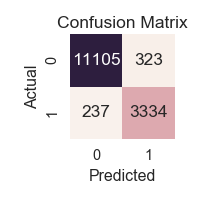

In [21]:
plt.figure(figsize=(2.5,2.5))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred),index=[0,1],columns=[0,1]), 
            square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout();

<IPython.core.display.Javascript object>


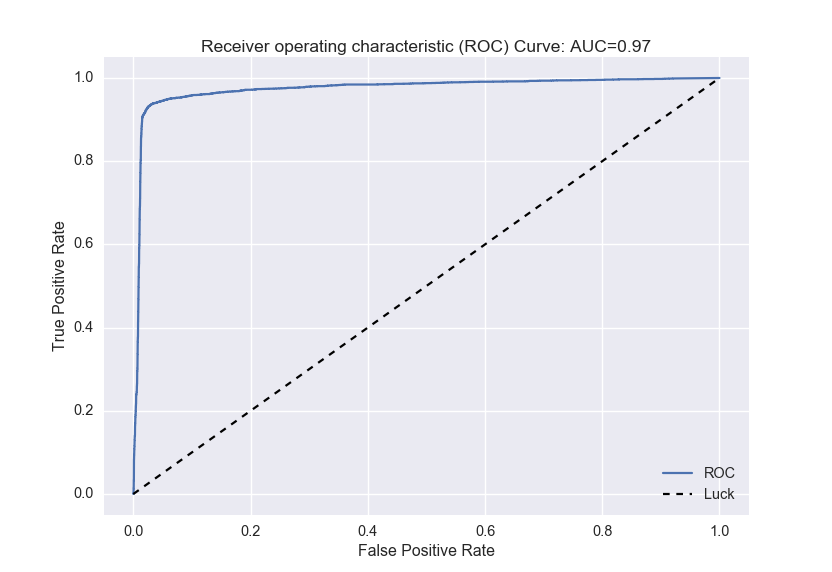

In [18]:
plot_roc(y_true,y_score[:,1])

<IPython.core.display.Javascript object>


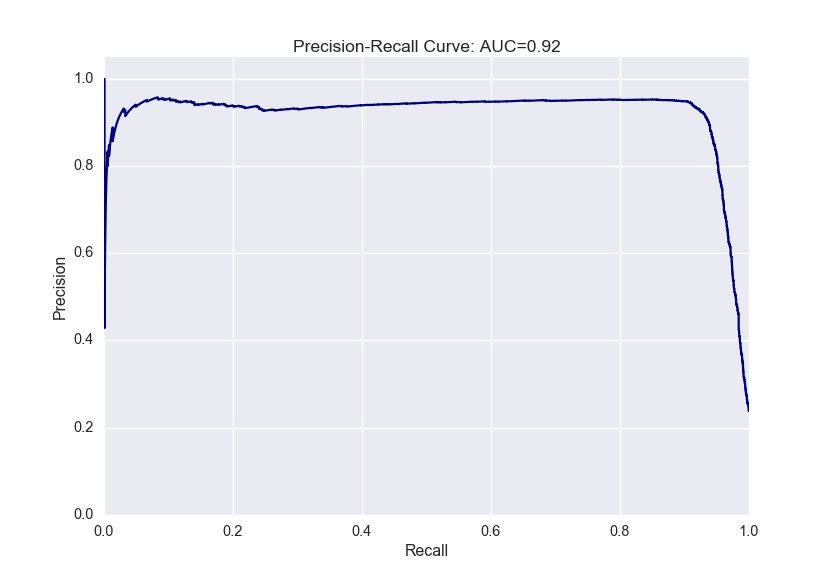

In [19]:
plot_pr(y_true,y_score[:,1])

SVM with the third degree polynomial and rbf kernel is able to achieve 96% accuracy; the linear kernel performs about as well as linear logistic regression. The area under the ROC curve for both is 97%, and the precision-recall curves are both over 90%, which is a much better performance than polynomial logistic regression.

<a href=#contents>(back to top)</a>

## 4. Discussion <a name='discussion' />

Random forest was the best model for our data, for prediction and for suggesting which features had the most impact. The data, when explored in pair plots, was highly non-linear, and collected in quilt-like patterns, which indicate conditional relationships, and that random forest is a good choice. The accuracy of the model even on test data approached 99%, with beautiful ROC and precision-recall curves. The features that random forest highlighted as the most important were satisfaction level, last evaluation, number of projects, monthly hours, and time spent at the company.

Logistic regression and SVM was also applied to the data. As might be expected, linear models like logistic regression and SVM with a linear kernel did not predict well, with accuracy little better than predicting that everyone stays. When interaction terms were added to the logistic regression, prediction vastly improved, but still only to 90% accuracy, which is still far below the 99% accuracy of random forest. SVM with the rbf kernel also did much better than the linear kernel, with an accuracy of 96% on test data, but again, random forest outperformed SVM, and also provides feature importance.

The features with the most importance from random forest modeling are:
 * satisfaction level
 * last evaluation
 * number of projects
 * average monthly hours
 * time spent at the company

<table>
<caption>Table of model performance metrics</caption>
<tr><th>Model</th><th>accuracy score</th><th>AUC-ROC</th><th>AUC-PR</th></tr>
<tr><td>baseline</td><td>0.76</td><td></td><td></td></tr>
<tr><td>logistic regression (linear)</td><td>0.77</td><td>0.80</td><td>0.45</td></tr>
<tr><td>logistic regression (polynomial deg=2)</td><td>0.85</td><td>0.91</td><td>0.69</td></tr>
<tr><td>logistic regression (polynomial deg=3)</td><td>0.83</td><td>0.91</td><td>0.73</td></tr>
<tr><td>logistic regression (interaction terms)</td><td>0.91</td><td>0.93</td><td>0.76</td></tr>
<tr><td>random forest</td><td>0.99</td><td>0.99</td><td>0.99</td></tr>
<tr><td>SVM (linear kernel)</td><td>0.77</td><td>0.79</td><td>0.50</td></tr>
<tr><td>SVM (rbf kernel)</td><td>0.96</td><td>0.97</td><td>0.91</td></tr>
<tr><td>SVM (3rd deg polynomial kernel)</td><td>0.96</td><td>0.97</td><td>0.92</td></tr>
</table>


<a href=#contents>(back to top)</a>

## 5. Recommendations <a name='recommendations' />

Because of uncertainties in motivations which cannot be answered by the current data set, we recommend to improve the resolution of the data being collected to include satisfaction level of work hours, work topic, sense of responsibility, and advancement. This will supplement existing data on average monthly hours, and if the employee was promoted in the last 5 years.

With regards to information we have, we know that there are three clusters of people who leave their job:
 1. 567 people who left with less than full time hours were not vastly unhappy, and had medium evaluations. It is unknown what led to these lukewarm satisfaction levels, and understanding if it was related to dissatisfaction about their hours, their tasks, or their evaluations would educate the employers on what actions they could take to retain these workers better. 
 1. 890 people who left worked overtime, had 4-5 projects, were very satisfied (rating of >0.7), and also have very good evaluations (>0.8). A possible interpretation is that the number projects felt manageable, hence the high satisfaction level, they worked overtime because they wanted to, and they left because they simply got better offers. The majority of leavers leave within 5 years and have not had a promotion in those 5 years. Possible actions are to provide perks that make the job more attractive, like higher salary (do a cost analysis of how much is lost by retraining a new person, and pay the high productivity employee this amount), more flexible working hours, more holiday, more stock options or equity, or anything else the company can offer at low to minimal cost.
 1. 886 people who left worked overtime, had 6-7 projects, were very unsatisfied (rating of 0.1), but had very high evaluations (>0.75). A possible interpretation is that the number of concurrent projects was too overwhelming, leading to the forced overtime, and a desire to leave and find a more manageable situation. The employer could lessen the load of these unsatisfied high performers (potentially promoting parttime employees to full time and with more projects).

In terms of priority actions, the employer could reduce churn by reducing the work load of the third group who are overworked. All people with 7 projects leave, and the majority of people with 6 projects leave. By reducing from their workload they might reduce the churn rate of people with 6-7 projects from 64% to the churn rate of people with 4-5 projects 14%. It would be helpful to know the cost to the company of losing these highly productive people and retraining new employees - this cost could be invested in keeping these highly productive people.

more discussion on confusion matrix, auc, what the numbers mean. balance of false neg vs pos?


<a href=#contents>(back to top)</a>